# Building a CNN for CIFAR-10 Classification with Regularization Strategies

This notebook focuses on the implementation of a Convolutional Neural Network (CNN) for the classification of the CIFAR-10 dataset. The primary goal is to build a robust model capable of accurately classifying images from the CIFAR-10 dataset, which consists of 32x32 color images in 10 different classes. In addition to the CNN architecture, the notebook explores regularization strategies to mitigate overfitting, a common challenge in deep learning. Regularization techniques such as dropout and data augmentation will be incorporated to enhance the model's generalization performance and prevent it from memorizing the training data excessively. Through step-by-step code implementation and analysis, this notebook aims to provide a comprehensive understanding of building CNN models for image classification tasks, emphasizing the importance of regularization in improving model performance on unseen data.

In [1]:
# Import necesary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to: {device}")

Device set to: cuda


# Data Loading and Balanced Subset Creation

The following code defines a function, `get_data_loaders`, to load and preprocess the CIFAR-10 dataset, creating balanced subsets for training, validation, and testing. We only use a subset of CIFAR for testing different models and regularization strategies on a smaller dataset.

## PyTorch Dataset
In PyTorch, a Dataset is an abstract class that provides an interface for accessing and loading data. It is a crucial component of PyTorch’s torch.utils.data module and is typically used to handle large datasets efficiently.
A Dataset in PyTorch:
Represents a collection of data (e.g., images, text, or tabular data).
Implements the __getitem__() method to retrieve individual data points.
Implements the __len__() method to return the total number of samples.
Can be used with DataLoader for efficient batching and shuffling.

## PyTorch DataLoader
The DataLoader in PyTorch is a utility that efficiently loads data from a Dataset, particularly when working with large datasets. It is part of the torch.utils.data module and is commonly used in deep learning pipelines to enable: 
 - Batching: Loads multiple samples at once instead of one-by-one.
 - Shuffling: Randomizes data order to prevent model overfitting.
 - Parallel Data Loading: Uses multiple workers for faster data loading.
 - Automatic Collation: Combines samples into mini-batches.

## Function Description

The `get_data_loaders` function takes a pytorch transform instance (`transform_train`) and a batch size as parameters. It returns three data loaders for training, validation, and testing, along with the class names of CIFAR-10.

1. **Data Transformation:**
    - In PyTorch, a transform is a function or a set of operations applied to data (such as images, tensors, or other inputs) to preprocess or augment it before feeding it into a deep learning model.
    - A basic data transformation is defined to convert images to tensors and normalize them, which is a necesary step when working with images.
    - If a train_transform is given, then a new dataset with that transform for the train DataLoader is created. So the transform for images in the train set can be different to that in the validation and test sets.
    - In Torchvision, which is a PyTorch package for image processing, transforms are used specifically for preprocessing and data augmentation of images, such as resizing, cropping, normalization, and converting images to tensors. We will make use of such functionality later when we include data augmentation in our training.
    
2. **Loading CIFAR-10 Dataset:**
    - The full CIFAR-10 dataset is loaded with the basic defined transformation.
    - If a specific transformation for training (`transform_train`) is provided, a new dataset with that transformation is created; otherwise, the original dataset is used for training. Nothe that the data is the same, what changes is that the train dataset will apply different transformations to the data.

3. **Balanced Subset Creation:**
    - A balanced subset is created to ensure equal representation of each class.
    - Indices for each class are stored in a dictionary (`class_indices_dict`).
    - The code iterates over the dataset, collecting indices for each class.

4. **Splitting:**
    - A balanced subset of indices is obtained by sampling an equal number of instances from each class.
    - The indices are split into training, validation, and test sets.

5. **Creating Subsets and Data Loaders:**
    - Subsets are created using the `Subset` class from PyTorch.
    - Data loaders are created for training, validation, and testing.

6. **Return Values:**
    - The function returns the data loaders for training, validation, and testing, along with the class names.

### Creating Dataloaders

To load the data, the `get_data_loaders` function is called with the training transformation and a batch size of 128. The resulting data loaders (`train_loader`, `val_loader`, `test_loader`), and class names (`class_names`) are obtained.



In [2]:
# Function to Get Data Loaders for CIFAR-10 Dataset

# This function takes a transformation for training data and a batch size as input and returns train, validation, and test data loaders along with class names.

def get_data_loaders(transform_train, batch_size=128):
    # Create a transform to convert images to tensors and normalize them
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load the full CIFAR10 dataset
    dataset_ = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

    # If a train_transform is given, create a new dataset with that transform for the train DataLoader
    if transform_train is None:
        dataset_train = dataset_
    else:
        dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)

    # Get the class names of CIFAR-10
    class_names = dataset_.classes

    # Define the size of the train, validation, and test sets
    train_size = 5000
    val_size = 1000
    test_size = 1000
    subset_size = train_size + val_size + test_size 

    # Create a balanced subset
    # Use a dictionary to store indices for each class
    # Initialize an empty dictionary, where keys are class indices and values are lists to store indices for each class.
    class_indices_dict = {class_idx: [] for class_idx in range(len(class_names))}

    # Iterate over the dataset to collect indices for each class
    # Iterate through the dataset, extract the index `i` and label from each element, and append the index to the corresponding class in the dictionary.
    for i, (_, label) in enumerate(dataset_):
        class_indices_dict[label].append(i)

    # Split the indices into training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []

    train_size_per_class = train_size // len(class_names)
    val_size_per_class = val_size // len(class_names)
    test_size_per_class = test_size // len(class_names)
    for idx in range(len(class_names)):
        indices = class_indices_dict[idx][:subset_size]
        train_indices.extend(indices[:train_size_per_class])
        val_indices.extend(indices[train_size_per_class:train_size_per_class + val_size_per_class])
        test_indices.extend(indices[train_size_per_class + val_size_per_class:train_size_per_class + val_size_per_class + test_size_per_class])

    # Create subsets
    train_dataset = Subset(dataset_train, train_indices)
    val_dataset = Subset(dataset_, val_indices)
    test_dataset = Subset(dataset_, test_indices)

    # Create data loader for the training set with WeightedRandomSampler
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # Create data loader for the validation set
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
    # Create data loader for the test set
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader, class_names

# Load the data
train_loader, val_loader, test_loader, class_names = get_data_loaders(None, batch_size=256)



100%|██████████| 170498071/170498071 [00:06<00:00, 24414413.87it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


### Visualizing the data

Here, we can visualize a set of one sample image per class from the CIFAR-10 dataset. 
It utilizes a dictionary, class_samples, to store one image for each class. The code iterates through the training dataset using a DataLoader, extracting images and labels. For each image, if there is no sample image stored for its corresponding class in class_samples, it is stored. The loop breaks once at least one sample image for each class is found. Finally, the code visualizes these sampled images, presenting a grid of images with corresponding class labels. This process provides a representative glimpse of the variety present in the CIFAR-10 dataset across different classes.

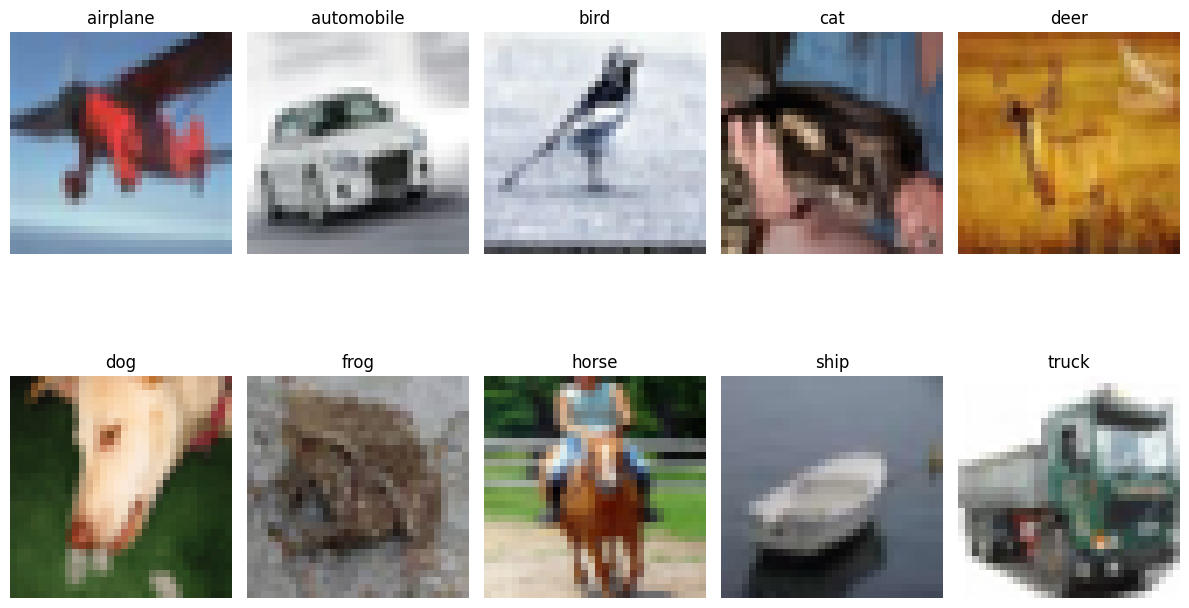

In [3]:
def visualize_data(class_names, data_loader):
    # Create a dictionary to store one sample image per class
    class_samples = {class_name: None for class_name in class_names}
    # Find one sample image for each class
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            if class_samples[class_names[label]] is None:
                class_samples[class_names[label]] = image
                # Break once a sample is found for each class
                if all(sample is not None for sample in class_samples.values()):
                    break

    # Visualize one sample from each class
    plt.figure(figsize=(12, 8))
    for i, (class_name, sample_image) in enumerate(class_samples.items()):
        plt.subplot(2, 5, i + 1)
        sample_image = sample_image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        plt.imshow((sample_image + 1) / 2)  # Denormalize the image
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_data(class_names, train_loader)

We can also check if the classes are balanced in our test set. To do that, we create and plot a histogram of labels in the data by checking all the samples yielded by the dataloader.

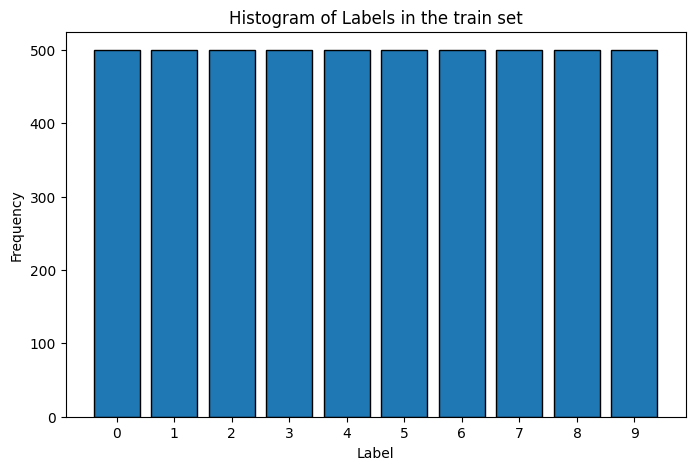

In [4]:

# Extract labels from the subset
subset_labels = []

for _, labels in train_loader:
    # Assuming labels are a tensor, we convert them to a list and extend our accumulating list
    subset_labels.extend(labels.tolist())

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(subset_labels, bins=range(11), edgecolor='black', align='left', rwidth=0.8)
plt.title('Histogram of Labels in the train set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.show()

# Simple CNN Model Definition

In this section, we define a simple Convolutional Neural Network (CNN) using PyTorch. The purpose of this model is to classify images from the CIFAR-10 dataset into one of the ten predefined classes. The model architecture consists of convolutional layers followed by max-pooling layers, and fully connected layers for classification. Let's break down the key components:

## Model Architecture
1. **Convolutional Layers:**
   - `self.conv1`: The first convolutional layer takes the input (RGB images) and produces feature maps with 16 output channels. The kernel size is set to 3 and padding needs to be 1 to keep the input dimension.
   - `self.conv2`: The second convolutional layer takes the output of the first after the activation funtion and pooling are applied and produces a feature map with 32 channels, and has the the same kernel size and padding (3 and 1).
   - `self.conv3`: The third convolutional layer further increases the number of output channels to 64.

2. **Activation and Pooling:**
   - `self.relu`: Rectified Linear Unit (ReLU) activation function is applied after each convolutional layer to introduce non-linearity.
   - `self.pool`: Max-pooling layer with a kernel size of 2 and a stride of 2 is used to downsample the spatial dimensions.

3. **Fully Connected Layers:**
   - `self.fc1`: The first fully connected layer takes the flattened output from the last convolutional layer and maps it to 64 units.
   - `self.fc2`: The final fully connected layer maps the 64 units to the output space with 10 units, corresponding to the number of classes in CIFAR-10.

## Forward Pass
The `forward` method defines the forward pass of the model. It specifies how input data flows through the layers to produce the final output. Convolutional and pooling layers are followed by activation functions, and the fully connected layers provide the classification logits. Note that the same relu and pooling layers are used in several parts. That is ok as these layers do not have parameters and are only applying the same function to any input, so no separate layers are needed.

This simple CNN serves as a starting point for image classification tasks and can be further customized or extended for more complex problems.

# Task: Complete the CNN Model Definition

Your task is to complete the implementation of the forward pass in the `forward` method of the Simple CNN model. The provided architecture includes convolutional layers, activation functions, and fully connected layers. Your goal is to specify the correct input channels and sizes for the linear layers. Follow the instructions below:

### Convolutional Layers
* `self.conv2`: **Make sure that the second convolutional layer produces a feature map with 32 channels, and has the same kernel size 3 and padding 1**.


### Fully Connected Layers
- `self.fc1`: The first fully connected layer takes the flattened output from the last convolutional layer and maps it to 64 units. **Specify the correct number of input and output features**. To do this, you need to calculate what would the output size of the last convolutional layer be, given that the input are images of size 32 by 32 pixels.

Feel free to refer to the provided comments and model architecture for guidance. This task aims to reinforce your understanding of input dimensions in neural network layers. Once completed, you'll have a functional CNN model ready for training on the CIFAR-10 dataset.


In [5]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully Connected Layers
        fc1_in_features = 64 * 8 * 8
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third Convolutional Block
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten for Fully Connected Layers
        x = x.view(-1, self.fc1.in_features)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

## Training loop
This code follows the same logic as all other trainng loops in previous notebooks for MLPs, so no much detail is given here.
This code defines a training loop with validation for a PyTorch model. It iterates through epochs, performing training and validation steps, and tracks losses and accuracies. The training loop prints progress every 10 epochs and plots loss and accuracy curves. The model is set to training mode during the training loop and evaluation mode during validation to ensure proper behavior of layers like dropout.

In [6]:
# Training Loop with Validation
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    # Lists to store training and validation losses, and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Loop over epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Validation without gradient computation
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                total_val_loss += val_loss.item()

                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%, '
                f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Plotting the loss and accuracy over epochs
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return val_losses

## Training a simple CNN
Now, let's train a CNN on CIFAR 10. We will create a model and use the train and test function on to train and evaluate it.

Epoch [10/40], Training Loss: 1.3035, Training Accuracy: 53.64%, Validation Loss: 1.3977, Validation Accuracy: 48.50%
Epoch [20/40], Training Loss: 0.9506, Training Accuracy: 66.96%, Validation Loss: 1.3258, Validation Accuracy: 51.90%
Epoch [30/40], Training Loss: 0.6353, Training Accuracy: 78.18%, Validation Loss: 1.3733, Validation Accuracy: 55.80%
Epoch [40/40], Training Loss: 0.2906, Training Accuracy: 91.32%, Validation Loss: 1.7178, Validation Accuracy: 55.40%


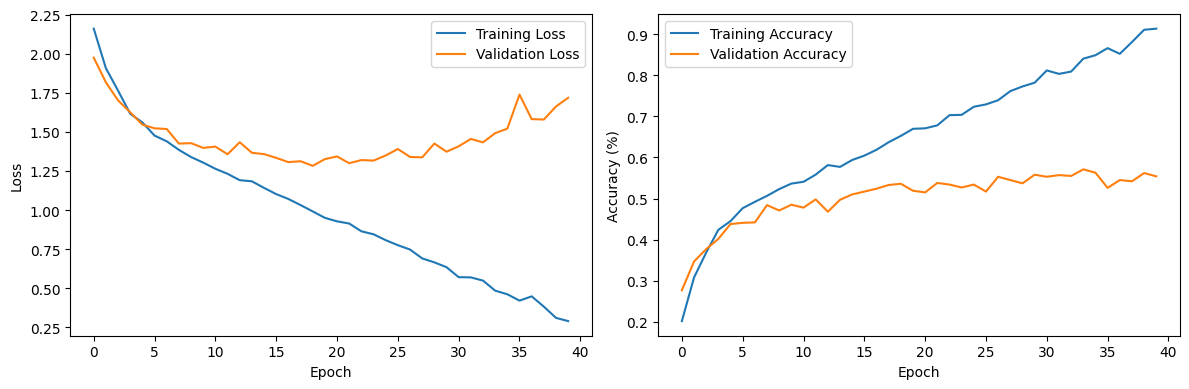

In [7]:
# Setting Hyperparameters and Training the Model

# Number of training epochs
epochs = 40

# Create an instance of the SimpleCNN model and move it to the specified device (GPU if available)
model = SimpleCNN().to(device)

# Define the loss criterion (CrossEntropyLoss) and the optimizer (Adam) for training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using the defined training function
val_losses_simple = train_model(model, train_loader, val_loader, epochs, criterion, optimizer)



The results should show a clear overfitting with the validation loss increasing while the training loss keeps decreasing.
* To address this, we will evaluate some regularization techniques.

## Dropout

Dropout is a regularization technique widely used in neural networks to mitigate overfitting. Proposed by Geoffrey Hinton and his collaborators, dropout involves randomly deactivating (dropping out) a fraction of neurons during training. This randomness prevents the network from relying too heavily on specific neurons, enhancing the model's generalization capabilities and reducing overfitting.

Below you need to work on the code that defines a simple CNN model with dropout. Dropout layers are applied after each convolution layer to randomly deactivate neurons during training, enhancing the model's generalization capabilities. The dropout probability is a hyperparameter that controls the fraction of neurons dropped out during each forward pass.

### Adding Dropout to a PyTorch CNN Model

In this section, we will guide you through the process of adding dropout to a Convolutional Neural Network (CNN) implemented in PyTorch. By introducing dropout layers, you can enhance the model's generalization capabilities.

### Task Overview
The goal is to modify the CNN model (without dropout) defined above to incorporate dropout layers at specific points in the architecture. Here is a step-by-step instructions to guide you through this process.

### Steps to Add Dropout
Follow these steps to add dropout to your PyTorch CNN model:

1. **Modify Model Class:**
   Inside your CNN model class, add `nn.Dropout` layers at appropriate locations in the architecture. Commonly, dropout is added after activation functions or between fully connected layers. In this case, you need to add three dropout layers in the definition. In the forward function the dropout layers need to be applied after the two pooling layer, and after the activation function of the third convolution.

2. **Adjust Dropout Probability:**
   Set the dropout probability (`dropout_prob`) when initializing `nn.Dropout` layers. This probability determines the fraction of neurons to drop during training. In this case, the dorpout_prob is given as an argument to the constructor of the class.

3. **Training and Evaluation Modes:**
   Ensure that dropout is active during training and inactive during evaluation. PyTorch handles this automatically, but you can use `model.train()` and `model.eval()` methods to switch modes explicitly.

4. **Experiment with Dropout Rate:**
   Experiment with different dropout rates to find an optimal value for your specific model and dataset. Common values range from 0.2 to 0.5.

### Example Code
Here's a snippet illustrating how to add dropout to a simple CNN model in PyTorch:

```python
class SimpleCNN_dropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNN_dropout, self).__init__()
        # ... (existing model layers)
        self.dropout1 = nn.Dropout(dropout_prob)
        # ... (more layers with dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        # ... (continue with modified layers)

```
In the code below make sure you:
* Add the three dropout layers with the given probability (dropout_prob)
* Include the dropout in the forward function


In [8]:
# Define a simple CNN model with dropout
class SimpleCNN_dropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNN_dropout, self).__init__()
        # Convolutional and dropout layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(dropout_prob)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolutional and pooling layers with ReLU activation
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Dropout applied after the first convolutional layer
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Dropout applied after the second convolutional layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu(x)
        # Dropout applied after the third convolutional layer
        x = self.dropout3(x)
        # Flatten the output for fully connected layers
        x = x.view(-1, self.fc1.in_features)
        # Fully connected layers with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


## Train a model with Dropout
Below we train a model with dropout, setting the rate to 0.5. 

* How do the results differ from the model without any regularization?

Epoch [10/100], Training Loss: 1.5136, Training Accuracy: 44.06%, Validation Loss: 1.5285, Validation Accuracy: 44.00%
Epoch [20/100], Training Loss: 1.3251, Training Accuracy: 52.10%, Validation Loss: 1.3765, Validation Accuracy: 49.50%
Epoch [30/100], Training Loss: 1.1767, Training Accuracy: 57.60%, Validation Loss: 1.2974, Validation Accuracy: 53.10%
Epoch [40/100], Training Loss: 1.0711, Training Accuracy: 61.54%, Validation Loss: 1.2551, Validation Accuracy: 53.60%
Epoch [50/100], Training Loss: 0.9857, Training Accuracy: 63.96%, Validation Loss: 1.2596, Validation Accuracy: 55.10%
Epoch [60/100], Training Loss: 0.8921, Training Accuracy: 67.58%, Validation Loss: 1.2736, Validation Accuracy: 54.40%
Epoch [70/100], Training Loss: 0.8025, Training Accuracy: 70.80%, Validation Loss: 1.2653, Validation Accuracy: 57.10%
Epoch [80/100], Training Loss: 0.7642, Training Accuracy: 72.84%, Validation Loss: 1.2978, Validation Accuracy: 56.00%
Epoch [90/100], Training Loss: 0.7031, Training 

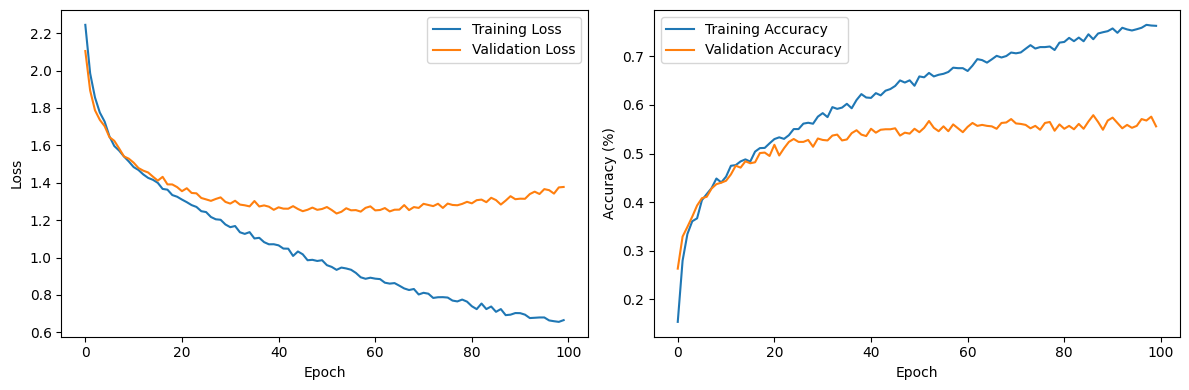

In [9]:
epochs = 100
model_d = SimpleCNN_dropout(dropout_prob=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d.parameters(), lr=0.001)
val_losses_dropout = train_model(model_d, train_loader, val_loader, epochs, criterion, optimizer)

Using dropout should decrease the overfitting. Do you see the difference in the training progress when comparing it with the case where no dropout was used?

## Data Augmentation in PyTorch

Data augmentation is a technique widely used in machine learning and computer vision to artificially increase the diversity of a dataset. The idea is to apply various transformations to the existing dataset, generating new, slightly altered versions of the original images. This helps improve the model's generalization and robustness by exposing it to a broader range of variations.

### Benefits of Data Augmentation
1. **Increased Diversity:**
   Augmented data provides a more comprehensive representation of the real-world scenarios the model might encounter.

2. **Reduced Overfitting:**
   By training on augmented data, the model becomes less prone to overfitting, as it learns to recognize patterns under various conditions.

3. **Improved Robustness:**
   Exposure to diverse transformations enhances the model's ability to handle variations in lighting, orientation, and other factors.

### Common Data Augmentation Techniques
1. **Rotation:**
   Randomly rotating images by a certain degree.

2. **Horizontal Flip:**
   Flipping images horizontally to simulate reflections.

3. **Zooming:**
   Randomly zooming in or out of images.

4. **Crop and Resize:**
   Randomly cropping and resizing images.

5. **Brightness and Contrast Adjustment:**
   Adjusting the brightness and contrast levels randomly.

### Data Augmentation in PyTorch
PyTorch provides convenient tools for implementing data augmentation through the `transforms` module. The `transforms` module allows you to chain multiple transformations together and apply them to your dataset during training.

Here's a basic example of how to apply data augmentation using PyTorch:

```python
import torchvision.transforms as transforms

# Define a series of augmentation transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=30),  # Randomly rotate images by a maximum of 20 degrees
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0), ratio=(0.8, 1.3)),  # Randomly crop and resize images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue randomly
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values to a range of [0, 1]
])


# Apply the transformations to your dataset during training
augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)


# Task: Implementing Data Augmentation

In this task, your goal is to enhance the existing Convolutional Neural Network (CNN) model for image classification on the CIFAR-10 dataset. You will implement two crucial techniques: dropout regularization and data augmentation.

**Objective:** Increase the model's robustness by introducing variations in the training data.

**Hints:**
1. **Transformation Definition:** Create a set of data augmentation transformations using `transforms.Compose`.
    - Include operations like random horizontal flip, random rotation, and color jittering.
    - Do not forget that you need to transform images to tensors and normalize them using the ToTensor and Normalize functions. These must be applied after all the augmentations.

2. **Data Loader Configuration:** Apply the defined transformations to the training data loader.
    - Use the `get_data_loaders` function and pass the `transform_train` to the `transform_train` parameter.



In [ ]:
# Set the number of epochs and batch size
epochs = 100

# Create a CNN model with dropout
model_d = SimpleCNN_dropout(dropout_prob=0.3).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d.parameters(), lr=0.001)

# Define data augmentation transformations for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=30),  # Randomly rotate images by a maximum of 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue randomly
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values to a range of [0, 1]
])

# Create data loaders for training, validation, and testing using the defined transformations
train_loader, val_loader, test_loader, _ = get_data_loaders(transform_train)




Files already downloaded and verified
Files already downloaded and verified


### Visualize the data with transformations
Before training let's visualize some images from the training set with some random transformation using the visualization function and calling it with our new train DataLoader.

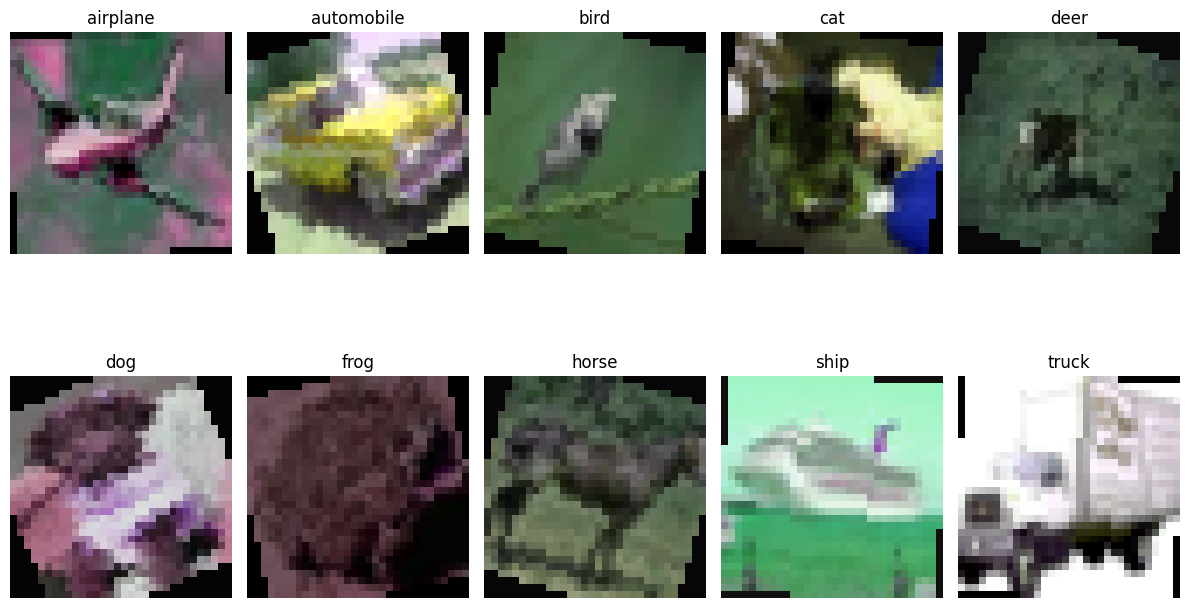

In [11]:
visualize_data(class_names, train_loader)

With these samples you should be able to see some of the trainsformations in action and realize how they make the task more complicated for the model, which is what helps it extract more general features and thus generalize better.

Now ltet's train the model with data augmentation and dropout.

Epoch [10/100], Training Loss: 1.6077, Training Accuracy: 41.56%, Validation Loss: 1.5039, Validation Accuracy: 46.10%
Epoch [20/100], Training Loss: 1.4536, Training Accuracy: 47.80%, Validation Loss: 1.3449, Validation Accuracy: 50.70%
Epoch [30/100], Training Loss: 1.3515, Training Accuracy: 52.16%, Validation Loss: 1.2640, Validation Accuracy: 54.70%
Epoch [40/100], Training Loss: 1.2479, Training Accuracy: 55.44%, Validation Loss: 1.2209, Validation Accuracy: 55.30%
Epoch [50/100], Training Loss: 1.1866, Training Accuracy: 57.50%, Validation Loss: 1.2064, Validation Accuracy: 56.40%
Epoch [60/100], Training Loss: 1.1538, Training Accuracy: 58.58%, Validation Loss: 1.1649, Validation Accuracy: 57.10%
Epoch [70/100], Training Loss: 1.0908, Training Accuracy: 61.58%, Validation Loss: 1.1504, Validation Accuracy: 59.00%
Epoch [80/100], Training Loss: 1.0564, Training Accuracy: 62.10%, Validation Loss: 1.1420, Validation Accuracy: 59.50%
Epoch [90/100], Training Loss: 1.0522, Training 

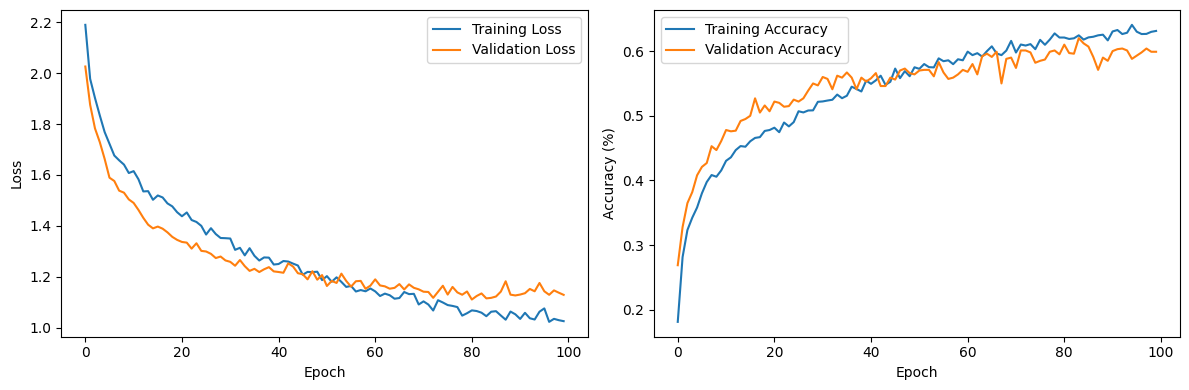

In [12]:
# Train the model
val_losses_data_aug = train_model(model_d, train_loader, val_loader, epochs, criterion, optimizer)

### Compare the trainings
Now that the three models have been trained, let's compare the progression of the validation loss for the three of them.

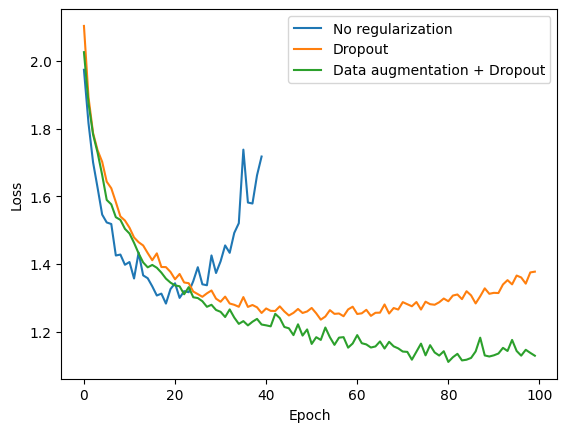

In [13]:
plt.plot(val_losses_simple, label='No regularization')
plt.plot(val_losses_dropout, label='Dropout')
plt.plot(val_losses_data_aug, label='Data augmentation + Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Testing the model
Here we create a function to test a model in a given test set.
This code defines a testing function that evaluates the model on a test dataset, calculates accuracy, F1 score, and generates a confusion matrix. The model is set to evaluation mode to disable layers like dropout and ensure consistent predictions during testing. The results are printed, and the confusion matrix is visualized with class names. The function returns accuracy and F1 score.

In [14]:
# Test the Model
def test_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize counters
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Disable gradient computation during testing
    with torch.no_grad():
        # Iterate through the test loader
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Update counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect labels and predictions for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total

    # Calculate F1 score
    f1 = f1_score(all_labels, all_predictions, average='macro')

    # Build confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix with class names
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Display test results
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f"F1 = {f1:.2f}")

    return accuracy, f1



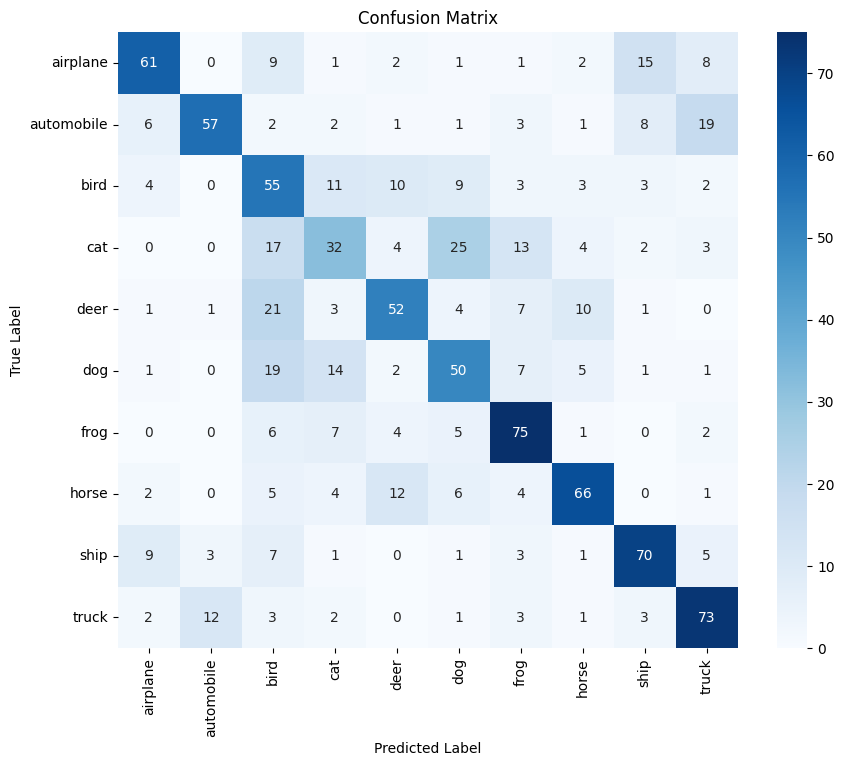

Test Accuracy: 59.10%
F1 = 0.59


In [15]:
# Test the model
acc, f1 = test_model(model_d, test_loader)

### Additional tasks you can try:
* Try different dropout probability to see how this affects the results.
* Add other data augmentation transformations like RandomResizedCrop.
* Implement L2 or weight decay regularization.